# Import modules & packpackages

In [1]:
import pandas as pd
import numpy as np
import re
import os
import string
from collections import defaultdict
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation # Added for LDA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
import gensim.downloader as api
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
print("Checking for and downloading required NLTK/Gensim data...")
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')
try:
    nltk.data.find('taggers/averaged_perceptron_tagger')
except LookupError:
    nltk.download('averaged_perceptron_tagger')
print("All necessary data is available.")

print("Loading pre-trained word vector model (glove-wiki-gigaword-100)...")
try:
    glove_vectors = api.load('glove-wiki-gigaword-100')
except Exception as e:
    print(f"Could not load model. Please ensure you have an internet connection. Error: {e}")
    exit()
print("Model loaded successfully.")

Checking for and downloading required NLTK/Gensim data...


[nltk_data] Downloading package wordnet to /Users/mia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


All necessary data is available.
Loading pre-trained word vector model (glove-wiki-gigaword-100)...
Model loaded successfully.


# Data Loading & Preprocessing

In [ ]:
SENTENCES2_TSV = 'sentences2.tsv'
SENTENCES3_TSV = 'sentences3.tsv'
LABELS1_TSV = 'labels1.tsv'
LABELS2_TSV = 'labels2.tsv'
DICTIONARY_FILENAME = "/Users/mia/Library/Mobile Documents/com~apple~CloudDocs/杜伦/Term 3/毕业论文/字典内容/Refined_dictionary.txt"


print("\n--- Loading and processing data ---")
try:
    sentence_df1 = pd.read_csv(SENTENCES2_TSV, sep='\t')
    sentence_df2 = pd.read_csv(SENTENCES3_TSV, sep='\t')
    sentences_df = pd.concat([sentence_df1, sentence_df2], ignore_index=True)
    sentences_df = sentences_df.sort_values(by=['Text-ID', 'Sentence-ID'])

    value_df1 = pd.read_csv(LABELS1_TSV, sep='\t')
    value_df2 = pd.read_csv(LABELS2_TSV, sep='\t')
    valueML_df = pd.concat([value_df1, value_df2], ignore_index=True)
    column_groups = {
        'SD': ['Self-direction: thought attained', 'Self-direction: thought constrained', 'Self-direction: action attained', 'Self-direction: action constrained'],
        'ST': ['Stimulation attained', 'Stimulation constrained'], 'HE': ['Hedonism attained', 'Hedonism constrained'],
        'AC': ['Achievement attained', 'Achievement constrained'],
        'PO': ['Power: dominance attained', 'Power: dominance constrained', 'Power: resources attained', 'Power: resources constrained'],
        'SE': ['Security: personal attained', 'Security: personal constrained', 'Security: societal attained', 'Security: societal constrained'],
        'TR': ['Tradition attained', 'Tradition constrained'],
        'CO': ['Conformity: rules attained', 'Conformity: rules constrained', 'Conformity: interpersonal attained', 'Conformity: interpersonal constrained'],
        'BE': ['Benevolence: caring attained', 'Benevolence: caring constrained', 'Benevolence: dependability attained', 'Benevolence: dependability constrained'],
        'UN': ['Universalism: concern attained', 'Universalism: concern constrained', 'Universalism: nature attained', 'Universalism: nature constrained', 'Universalism: tolerance attained', 'Universalism: tolerance constrained']
    }
    professional_df = valueML_df[['Text-ID', 'Sentence-ID']].copy()
    for main_label, sub_columns in column_groups.items():
        professional_df[main_label] = valueML_df[sub_columns].sum(axis=1, skipna=True)
    
    ALL_VALUE_TYPES = list(column_groups.keys()) 

    print(f"Text data loaded with {len(sentences_df)} records.")
    print(f"Expert score data processed for {len(professional_df)} records.")

except FileNotFoundError as e:
    print(f"ERROR: File not found: {e.filename}. Please check your file paths.")
    exit()

def read_pvd_dictionary(filepath):
    value_mapping, pvd_dict = {}, {}
    with open(filepath, 'r', encoding='utf-8') as f:
        in_header = False
        for line in f:
            line = line.strip()
            if not line: continue
            if line == '%':
                in_header = not in_header
                continue
            if in_header:
                num_str, value_str = line.split('\t')
                value_mapping[num_str] = value_str.replace('Values_', '') 
            else:
                word, num_str = line.split('\t')
                if num_str in value_mapping:
                    value_category = value_mapping[num_str] 
                    if value_category not in pvd_dict:
                        pvd_dict[value_category] = set()
                    pvd_dict[value_category].add(word.split('#')[0])
    return pvd_dict

parsed_pvd = read_pvd_dictionary(DICTIONARY_FILENAME)
print(f"PVD Dictionary loaded with {sum(len(v) for v in parsed_pvd.values())} total word entries.")


def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text) # Remove punctuation
    text = re.sub(r'\d+', '', text)    # Remove numbers
    return text

sentences_df['Cleaned_Text'] = sentences_df['Text'].apply(lambda x: clean_text(x))


--- Loading and processing data ---
Text data loaded with 59662 records.
Expert score data processed for 59662 records.
PVD Dictionary loaded with 1068 total word entries.


# Data Alignment and Final Preparation

In [ ]:
master_df = pd.merge(sentences_df, professional_df, on=['Text-ID', 'Sentence-ID'])
master_df.dropna(subset=list(column_groups.keys()), inplace=True)
print(f"Merged master dataframe created with {len(master_df)} aligned records.")

aggregated_pvd = {abbr: set() for abbr in ['SD', 'ST', 'HE', 'AC', 'PO', 'SE', 'TR', 'CO', 'BE', 'UN']}
for category, words in parsed_pvd.items():
    if category in aggregated_pvd:
        aggregated_pvd[category].update(words)
    else:
        print(f"WARNING: Unknown category '{category}' in dictionary")
        
print("\nAfter Aggregation")
total_aggregated_words = 0
for abbr, words in aggregated_pvd.items():
    print(f"{abbr}: {len(words)} words")
    if words:
        print(f"  Sample words: {list(words)[:3]}")
    total_aggregated_words += len(words)
print(f"Total aggregated words: {total_aggregated_words}")

print("PVD dictionary aggregated to match expert score columns.")

corpus = master_df['Cleaned_Text'].tolist()
expert_scores_df = master_df[list(column_groups.keys())]

print("\nStatistical Summary of Expert Scores")
print(expert_scores_df.describe().round(4).to_string())

Merged master dataframe created with 59662 aligned records.

--- After Aggregation ---
SD: 140 words
  Sample words: ['effort', 'distinctive', 'famous']
ST: 120 words
  Sample words: ['motivation', 'discoveries', 'energetic']
HE: 97 words
  Sample words: ['lure', 'enjoying', 'delighted']
AC: 88 words
  Sample words: ['approval', 'honors', 'progress']
PO: 102 words
  Sample words: ['strengthened', 'rich', 'agency']
SE: 85 words
  Sample words: ['stable', 'danger', 'save']
TR: 109 words
  Sample words: ['religions', 'atheist', 'orthodox']
CO: 129 words
  Sample words: ['periodic', 'procedure', 'abide']
BE: 95 words
  Sample words: ['companion', 'confidence', 'guidance']
UN: 103 words
  Sample words: ['democracy', 'greedy', 'protection']
Total aggregated words: 1068
PVD dictionary aggregated to match expert score columns.

--- 2.1 Statistical Summary of Expert Scores ---
               SD          ST          HE          AC          PO          SE          TR          CO          BE      

# Text Preprocessing & Tokenization Strategies

In [7]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def process_corpus_text_with_stopwords(cleaned_text, strategy='exact'):
    tokens = word_tokenize(cleaned_text)
    tokens = [word for word in tokens if word not in stop_words]

    if strategy == 'stem':
        return [stemmer.stem(word) for word in tokens]
    elif strategy == 'lemmatize':
        return [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in tokens]
    elif strategy == 'exact':
        return tokens
    else:
        raise ValueError("Unknown tokenization strategy.")

def process_corpus_text_no_stopwords(cleaned_text, strategy='exact'):
    tokens = word_tokenize(cleaned_text)
    
    if strategy == 'stem':
        return [stemmer.stem(word) for word in tokens]
    elif strategy == 'lemmatize':
        return [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in tokens]
    elif strategy == 'exact':
        return tokens
    else:
        raise ValueError("Unknown tokenization strategy.")

# Scoring and Ipsatisation Functions

In [8]:
def calculate_raw_scores(processed_corpus_tokens, pvd_dict, vec_tech, vectorizer_model=None, binary_score=True):
    num_docs = len(processed_corpus_tokens)
    scores = pd.DataFrame(0.0, index=range(num_docs), columns=pvd_dict.keys())

    if vec_tech == 'embedding_similarity':
        value_vectors = {}
        for value, keywords in pvd_dict.items():
            word_vectors = [glove_vectors[word] for word in keywords if word in glove_vectors]
            if word_vectors:
                value_vectors[value] = np.mean(word_vectors, axis=0).reshape(1, -1)
        
        if not value_vectors:
            return scores

        for i, doc_tokens in enumerate(processed_corpus_tokens):
            doc_word_vectors = [glove_vectors[token] for token in doc_tokens if token in glove_vectors]
            if not doc_word_vectors: continue
            doc_vector = np.mean(doc_word_vectors, axis=0).reshape(1, -1)
            for value, value_vec in value_vectors.items():
                if value in value_vectors:
                    scores.at[i, value] = cosine_similarity(doc_vector, value_vec)[0][0]

    elif vec_tech == 'embedding_counting':
        pvd_centroids = {}
        for value, keywords in pvd_dict.items():
            vectors = [glove_vectors[word] for word in keywords if word in glove_vectors]
            if vectors:
                pvd_centroids[value] = np.mean(vectors, axis=0)
        
        if not pvd_centroids:
            return scores

        value_labels = list(pvd_centroids.keys())
        centroid_matrix = np.array([pvd_centroids[label] for label in value_labels])
        threshold = 0.4

        for i, doc_tokens in enumerate(processed_corpus_tokens):
            doc_scores = {value: 0 for value in pvd_dict.keys()}
            for token in doc_tokens:
                if token in glove_vectors:
                    token_vec = glove_vectors[token].reshape(1, -1)
                    similarities = cosine_similarity(token_vec, centroid_matrix)[0]
                    max_similarity_index = np.argmax(similarities)
                    if similarities[max_similarity_index] > threshold:
                        best_match_value = value_labels[max_similarity_index]
                        doc_scores[best_match_value] += 1
            for value, score in doc_scores.items():
                scores.at[i, value] = 1 if score > 0 else 0

    elif vec_tech in ['bow', 'tfidf_binary', 'tfidf_continuous']:
        vocab_map = vectorizer_model.vocabulary_
        doc_term_matrix = vectorizer_model.transform([" ".join(doc) for doc in processed_corpus_tokens]).toarray()
        for value, keywords in pvd_dict.items():
            keyword_indices = [vocab_map[word] for word in keywords if word in vocab_map]
            if not keyword_indices: continue
            
            value_scores = doc_term_matrix[:, keyword_indices].sum(axis=1)
            if binary_score:
                scores[value] = (value_scores > 0).astype(int)
            else:
                scores[value] = value_scores

    return scores

def ipsatise_scores(raw_scores_df):
    mean_scores = raw_scores_df.mean(axis=1)
    return raw_scores_df.subtract(mean_scores, axis=0)

# Evaluation Metrics

In [9]:
def evaluate_performance(automated_scores, expert_scores):
    metrics = {}
    correlations = {}
    for value_dim in automated_scores.columns:
        auto_series = automated_scores[value_dim]
        expert_series = expert_scores[value_dim].reset_index(drop=True)
        if auto_series.std() > 0 and expert_series.std() > 0:
            corr, _ = pearsonr(auto_series, expert_series)
            correlations[value_dim] = corr if not np.isnan(corr) else 0.0
        else:
            correlations[value_dim] = 0.0
    metrics['dimensional_correlation'] = correlations
    metrics['avg_dimensional_correlation'] = np.mean(list(correlations.values()))

    profile_corrs = []
    for i in range(len(automated_scores)):
        auto_row = automated_scores.iloc[i]
        expert_row = expert_scores.iloc[i]
        if auto_row.std() > 0 and expert_row.std() > 0:
            corr, _ = pearsonr(auto_row, expert_row)
            profile_corrs.append(corr if not np.isnan(corr) else 0.0)
        else:
            profile_corrs.append(0.0)
    metrics['avg_profile_correlation'] = np.mean(profile_corrs)
    metrics['mae'] = mean_absolute_error(expert_scores, automated_scores)
    metrics['rmse'] = np.sqrt(mean_squared_error(expert_scores, automated_scores))
    return metrics

# Set LDA Model
首先确定最佳的主题个数，并根据最佳的k值生成对应数值的主题。


--- Starting LDA Model Tuning ---
  > Training LDA model with k=5...
  > Training LDA model with k=10...
  > Training LDA model with k=15...
  > Training LDA model with k=20...
  > Training LDA model with k=25...
  > Training LDA model with k=30...
  > Training LDA model with k=35...
  > Training LDA model with k=40...
  > Training LDA model with k=45...
  > Training LDA model with k=50...


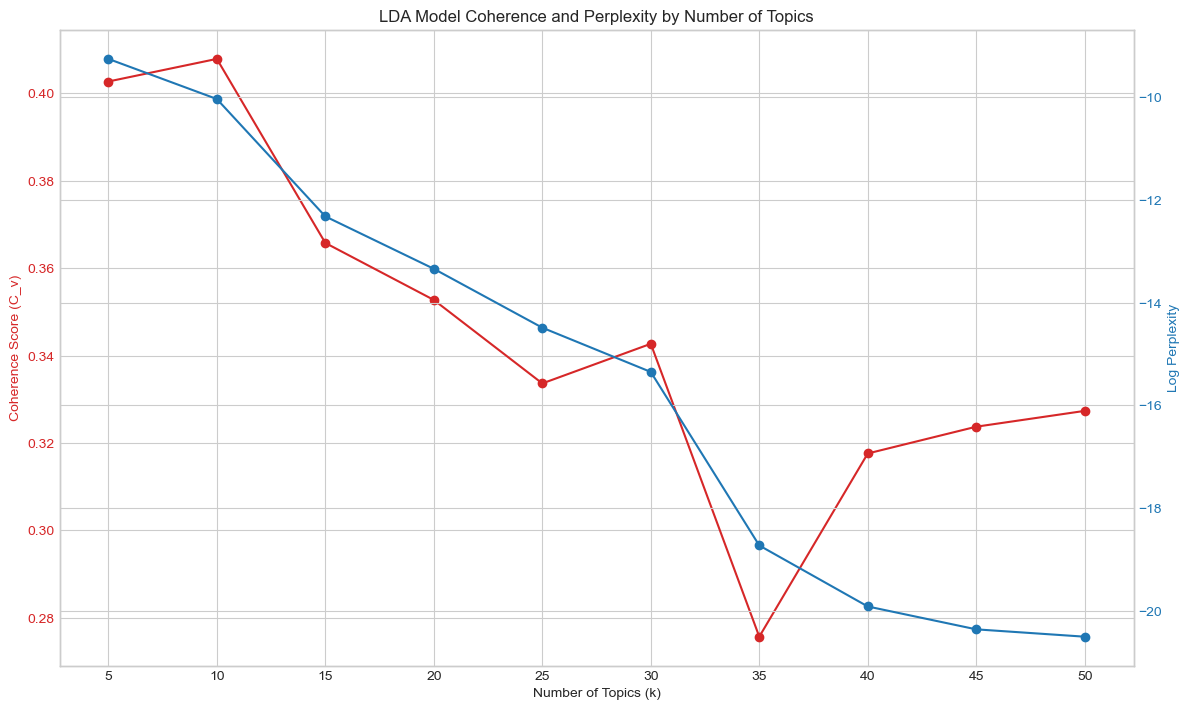


--- LDA Model Tuning Scores ---
k = 5: Coherence = 0.4027, Log Perplexity = -9.2484
k = 10: Coherence = 0.4079, Log Perplexity = -10.0303
k = 15: Coherence = 0.3658, Log Perplexity = -12.3174
k = 20: Coherence = 0.3527, Log Perplexity = -13.3385
k = 25: Coherence = 0.3336, Log Perplexity = -14.4858
k = 30: Coherence = 0.3427, Log Perplexity = -15.3478
k = 35: Coherence = 0.2757, Log Perplexity = -18.7290
k = 40: Coherence = 0.3176, Log Perplexity = -19.9174
k = 45: Coherence = 0.3237, Log Perplexity = -20.3631
k = 50: Coherence = 0.3274, Log Perplexity = -20.5062


In [19]:
print("\n--- Starting LDA Model Tuning ---")

# Prepare data for Gensim
tokenized_texts_lda_tuning = [process_corpus_text_with_stopwords(doc, 'exact') for doc in corpus]
id2word = corpora.Dictionary(tokenized_texts_lda_tuning)
gensim_corpus = [id2word.doc2bow(text) for text in tokenized_texts_lda_tuning]

def compute_coherence_values(dictionary, corpus, texts, limit, start=5, step=5):
    """Compute c_v coherence for various number of topics."""
    coherence_values = []
    perplexity_values = []
    k_values = range(start, limit + 1, step)
    for k in k_values:
        print(f"  > Training LDA model with k={k}...")
        model = gensim.models.LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=k, random_state=100,
                                           chunksize=100, passes=10, per_word_topics=True)
        perplexity_values.append(model.log_perplexity(corpus))
        coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())
    return coherence_values, perplexity_values, list(k_values)

coherence, perplexity, k_vals = compute_coherence_values(
    dictionary=id2word, corpus=gensim_corpus, texts=tokenized_texts_lda_tuning, start=5, limit=50, step=5
)

# Plotting the results
try:
    fig, ax1 = plt.subplots(figsize=(12, 7))
    color = 'tab:red'
    ax1.set_xlabel('Number of Topics (k)')
    ax1.set_ylabel('Coherence Score (C_v)', color=color)
    ax1.plot(k_vals, coherence, 'o-', color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_xticks(k_vals)
    
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Log Perplexity', color=color)
    ax2.plot(k_vals, perplexity, 'o-', color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    
    fig.tight_layout()
    plt.title('LDA Model Coherence and Perplexity by Number of Topics')
    plt.grid(True)
    plt.show()
except Exception as e:
    print(f"\n[ERROR] Could not generate LDA tuning plot: {e}")

print("\n--- LDA Model Tuning Scores ---")
for i, k in enumerate(k_vals):
    print(f"k = {k}: Coherence = {coherence[i]:.4f}, Log Perplexity = {perplexity[i]:.4f}")


The model tuning process revealed that the peak coherence score was attained at k=10.

In [20]:
NUM_TOPICS = 10

lda_final_vectorizer = CountVectorizer(max_df=0.95, min_df=5, stop_words='english')
doc_term_matrix_final_lda = lda_final_vectorizer.fit_transform(corpus)

lda_final_model = LatentDirichletAllocation(n_components=NUM_TOPICS, random_state=42)
doc_topic_dist_final = lda_final_model.fit_transform(doc_term_matrix_final_lda)
doc_topic_dist_df = pd.DataFrame(doc_topic_dist_final, columns=[f'Topic_{i}' for i in range(NUM_TOPICS)])

def display_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = f"Topic #{topic_idx}: "
        message += " ".join([feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]])
        print(message)

display_topics(lda_final_model, lda_final_vectorizer.get_feature_names_out(), 10)

Topic #0: new cases years percent days number people patients law virus
Topic #1: said minister ministry meeting prime according years day report turkey
Topic #2: year billion million euros companies government bank crisis percent company
Topic #3: education school social children schools students people national teachers health
Topic #4: percent price gas prices years increase million rate tax year
Topic #5: people police according work public home family time working thousand
Topic #6: energy economic new development climate economy need public policy production
Topic #7: said people dont know like want good say think going
Topic #8: president european said countries russian eu war ukraine russia states
Topic #9: court state law workers government israel case minimum decision wage


# Main Experiment Loop

In [21]:
tokenization_strategies = ['exact', 'stem', 'lemmatize']
vectorization_techniques = ['bow', 'tfidf_binary', 'tfidf_continuous', 'embedding_similarity', 'embedding_counting', 'lda']

results = []
all_scores = {}
best_result = {'score': -np.inf, 'config': None}

topic_to_value_map = {
    'PO': [8],
    'SE': [5],
    'CO': [0, 9],
    'UN': [6],
    'BE': [3],
    'AC': [2, 4],
    'SD': [7],
    'TR': [1],
    'HE': [],
    'ST': []
}

print("\n--- Starting 3x6 Factorial Experiment ---")

def process_dict_word(word, strategy):
    """Processes a single word for the dictionary WITHOUT removing stopwords."""
    if strategy == 'stem': return stemmer.stem(word)
    elif strategy == 'lemmatize': return lemmatizer.lemmatize(word, get_wordnet_pos(word))
    return word

for token_strat in tokenization_strategies:
    print(f"\n--- Tokenization Strategy: {token_strat.upper()} ---")
    
    processed_pvd = {val: [process_dict_word(w, token_strat) for w in words] for val, words in aggregated_pvd.items()}
    pvd_vocabulary = sorted(list(set(word for words in processed_pvd.values() for word in words)))
    
    for vec_tech in vectorization_techniques:
        print(f"  > Vectorization: {vec_tech.upper()}")
        
        raw_scores = pd.DataFrame()
        combo_name = f"{token_strat}_{vec_tech}"
        
        if vec_tech == 'lda':
            processed_corpus_lda = [process_corpus_text_with_stopwords(doc, token_strat) for doc in corpus]
            lda_vectorizer = CountVectorizer(max_df=0.95, min_df=5) # Stopwords handled in processing
            doc_term_matrix_lda = lda_vectorizer.fit_transform([" ".join(doc) for doc in processed_corpus_lda])

            if doc_term_matrix_lda.shape[1] == 0:
                print("    - SKIPPING LDA due to empty vocabulary after vectorization.")
                results.append({'tokenization': token_strat, 'vectorization': vec_tech})
                continue

            lda_model = LatentDirichletAllocation(n_components=20, random_state=42)
            doc_topic_dist = lda_model.fit_transform(doc_term_matrix_lda)
            
            scores_df_lda_raw = pd.DataFrame(doc_topic_dist, columns=[f'Topic_{i}' for i in range(20)])
            raw_scores = pd.DataFrame(index=scores_df_lda_raw.index)
            for value, topic_indices in topic_to_value_map.items():
                if topic_indices:
                    relevant_topics = [f'Topic_{i}' for i in topic_indices]
                    raw_scores[value] = scores_df_lda_raw[relevant_topics].sum(axis=1)
                else:
                    raw_scores[value] = 0
            for value in ALL_VALUE_TYPES:
                if value not in raw_scores.columns:
                    raw_scores[value] = 0
        
        else: # For BoW, TF-IDF, and Embedding methods
            processed_corpus_dict = [process_corpus_text_no_stopwords(doc, token_strat) for doc in corpus]
            vectorizer = None
            if vec_tech in ['bow', 'tfidf_binary','tfidf_continuous']:
                if not pvd_vocabulary:
                    print(f"    - SKIPPING for '{token_strat}' due to empty vocabulary.")
                    results.append({'tokenization': token_strat, 'vectorization': vec_tech})
                    continue
                if vec_tech == 'bow':
                    vectorizer = CountVectorizer(vocabulary=pvd_vocabulary, token_pattern=r"(?u)\b\w+\b")
                elif vec_tech in ['tfidf_binary','tfidf_continuous']:
                    vectorizer = TfidfVectorizer(vocabulary=pvd_vocabulary, token_pattern=r"(?u)\b\w+\b")
                vectorizer.fit([" ".join(doc) for doc in processed_corpus_dict])
            
            raw_scores = calculate_raw_scores(processed_corpus_dict, processed_pvd, vec_tech, vectorizer)
        
        automated_ipsatised = ipsatise_scores(raw_scores)
        expert_ipsatised = ipsatise_scores(expert_scores_df)
        performance = evaluate_performance(automated_ipsatised, expert_ipsatised)

        current_score = performance['avg_dimensional_correlation']
        if not np.isnan(current_score) and current_score > best_result['score']:
            best_result['score'] = current_score
            best_result['config'] = (token_strat, vec_tech)
        
        all_scores[combo_name] = automated_ipsatised
        results.append({'tokenization': token_strat, 'vectorization': vec_tech, **performance})

print("\n--- Factorial Experiment Finished ---")


--- Starting 3x5 Factorial Experiment ---

--- Tokenization Strategy: EXACT ---
  > Vectorization: BOW
  > Vectorization: TFIDF_BINARY
  > Vectorization: TFIDF_CONTINUOUS
  > Vectorization: EMBEDDING_SIMILARITY
  > Vectorization: EMBEDDING_COUNTING
  > Vectorization: LDA

--- Tokenization Strategy: STEM ---
  > Vectorization: BOW
  > Vectorization: TFIDF_BINARY
  > Vectorization: TFIDF_CONTINUOUS
  > Vectorization: EMBEDDING_SIMILARITY
  > Vectorization: EMBEDDING_COUNTING
  > Vectorization: LDA

--- Tokenization Strategy: LEMMATIZE ---
  > Vectorization: BOW
  > Vectorization: TFIDF_BINARY
  > Vectorization: TFIDF_CONTINUOUS
  > Vectorization: EMBEDDING_SIMILARITY
  > Vectorization: EMBEDDING_COUNTING
  > Vectorization: LDA

--- Factorial Experiment Finished ---


# Results and Qualitative Analysis


--- Quantitative Evaluation Summary (Factorial Experiment) ---
   tokenization         vectorization  avg_dimensional_correlation  avg_profile_correlation     mae    rmse
0         exact                   bow                       0.1396                   0.0798  0.1790  0.3372
1         exact          tfidf_binary                       0.1396                   0.0798  0.1790  0.3372
2         exact      tfidf_continuous                       0.1396                   0.0798  0.1790  0.3372
3         exact  embedding_similarity                       0.1554                   0.1051  0.1460  0.2307
4         exact    embedding_counting                       0.1013                   0.0991  0.4450  0.4896
5         exact                   lda                       0.0030                   0.0102  0.1328  0.2575
6          stem                   bow                       0.1297                   0.0843  0.2513  0.3913
7          stem          tfidf_binary                       0.1297      

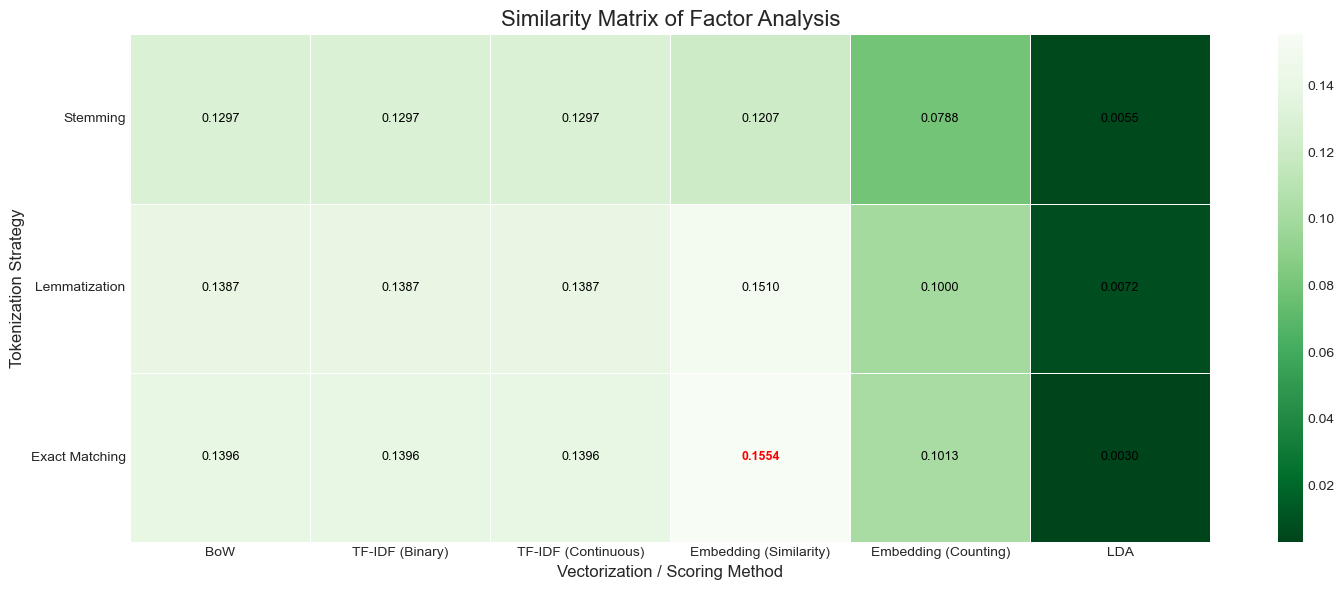

In [25]:
results_df = pd.DataFrame(results)
if not results_df.empty:
    results_df_summary = results_df.dropna(subset=['avg_dimensional_correlation']).copy()

    if not results_df_summary.empty:
        corr_df = results_df_summary['dimensional_correlation'].apply(pd.Series).add_prefix('corr_')
        results_df_display = results_df_summary.drop(['dimensional_correlation'], axis=1)
        results_df_display = pd.concat([results_df_display, corr_df], axis=1)

        print("\n--- Quantitative Evaluation Summary (Factorial Experiment) ---")
        print(results_df_display[['tokenization', 'vectorization', 'avg_dimensional_correlation', 'avg_profile_correlation', 'mae', 'rmse']].round(4).to_string())

        try:
            plt.style.use('seaborn-v0_8-whitegrid')
            results_df_summary['tokenization_display'] = results_df_summary['tokenization'].map({'exact': 'Exact Matching', 'lemmatize': 'Lemmatization', 'stem': 'Stemming'}).astype(pd.api.types.CategoricalDtype(categories=['Stemming', 'Lemmatization', 'Exact Matching'], ordered=True))
            results_df_summary['vectorization_display'] = results_df_summary['vectorization'].map({'bow': 'BoW', 'tfidf_binary': 'TF-IDF (Binary)', 'tfidf_continuous': 'TF-IDF (Continuous)', 'embedding_similarity': 'Embedding (Similarity)', 'embedding_counting': 'Embedding (Counting)', 'lda': 'LDA'})
            pivot_df = results_df_summary.pivot(index='tokenization_display', columns='vectorization_display', values='avg_dimensional_correlation')
            ordered_cols = ['BoW', 'TF-IDF (Binary)', 'TF-IDF (Continuous)', 'Embedding (Similarity)', 'Embedding (Counting)', 'LDA']
            pivot_df = pivot_df[ordered_cols]

            fig, ax = plt.subplots(figsize=(15, 6))
            max_val = pivot_df.max().max()
            max_pos = divmod(pivot_df.values.argmax(), pivot_df.shape[1]) 
            sns.heatmap(pivot_df, annot=False, fmt=".4f", cmap="Greens_r", linewidths=.5, ax=ax, cbar=True)

            for i in range(pivot_df.shape[0]):
                for j in range(pivot_df.shape[1]):
                    val = pivot_df.iloc[i, j]
                    color = "red" if (i, j) == max_pos else "black"
                    ax.text(j+0.5, i+0.5, f"{val:.4f}",
                            ha='center', va='center',
                            color=color, fontsize=9, fontweight='bold' if color=='red' else 'normal')
        
            ax.set_title('Similarity Matrix of Factor Analysis', fontsize=16)
            ax.set_xlabel('Vectorization / Scoring Method', fontsize=12)
            ax.set_ylabel('Tokenization Strategy', fontsize=12)
            plt.xticks(rotation=0)
            plt.yticks(rotation=0)
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"\n[ERROR] Could not generate quantitative heatmap: {e}")

else:
    print("\nNo results were generated from the factorial experiment.")

# Visualization for Best Model


--- Generating Detailed Performance Plots for Best Model ---


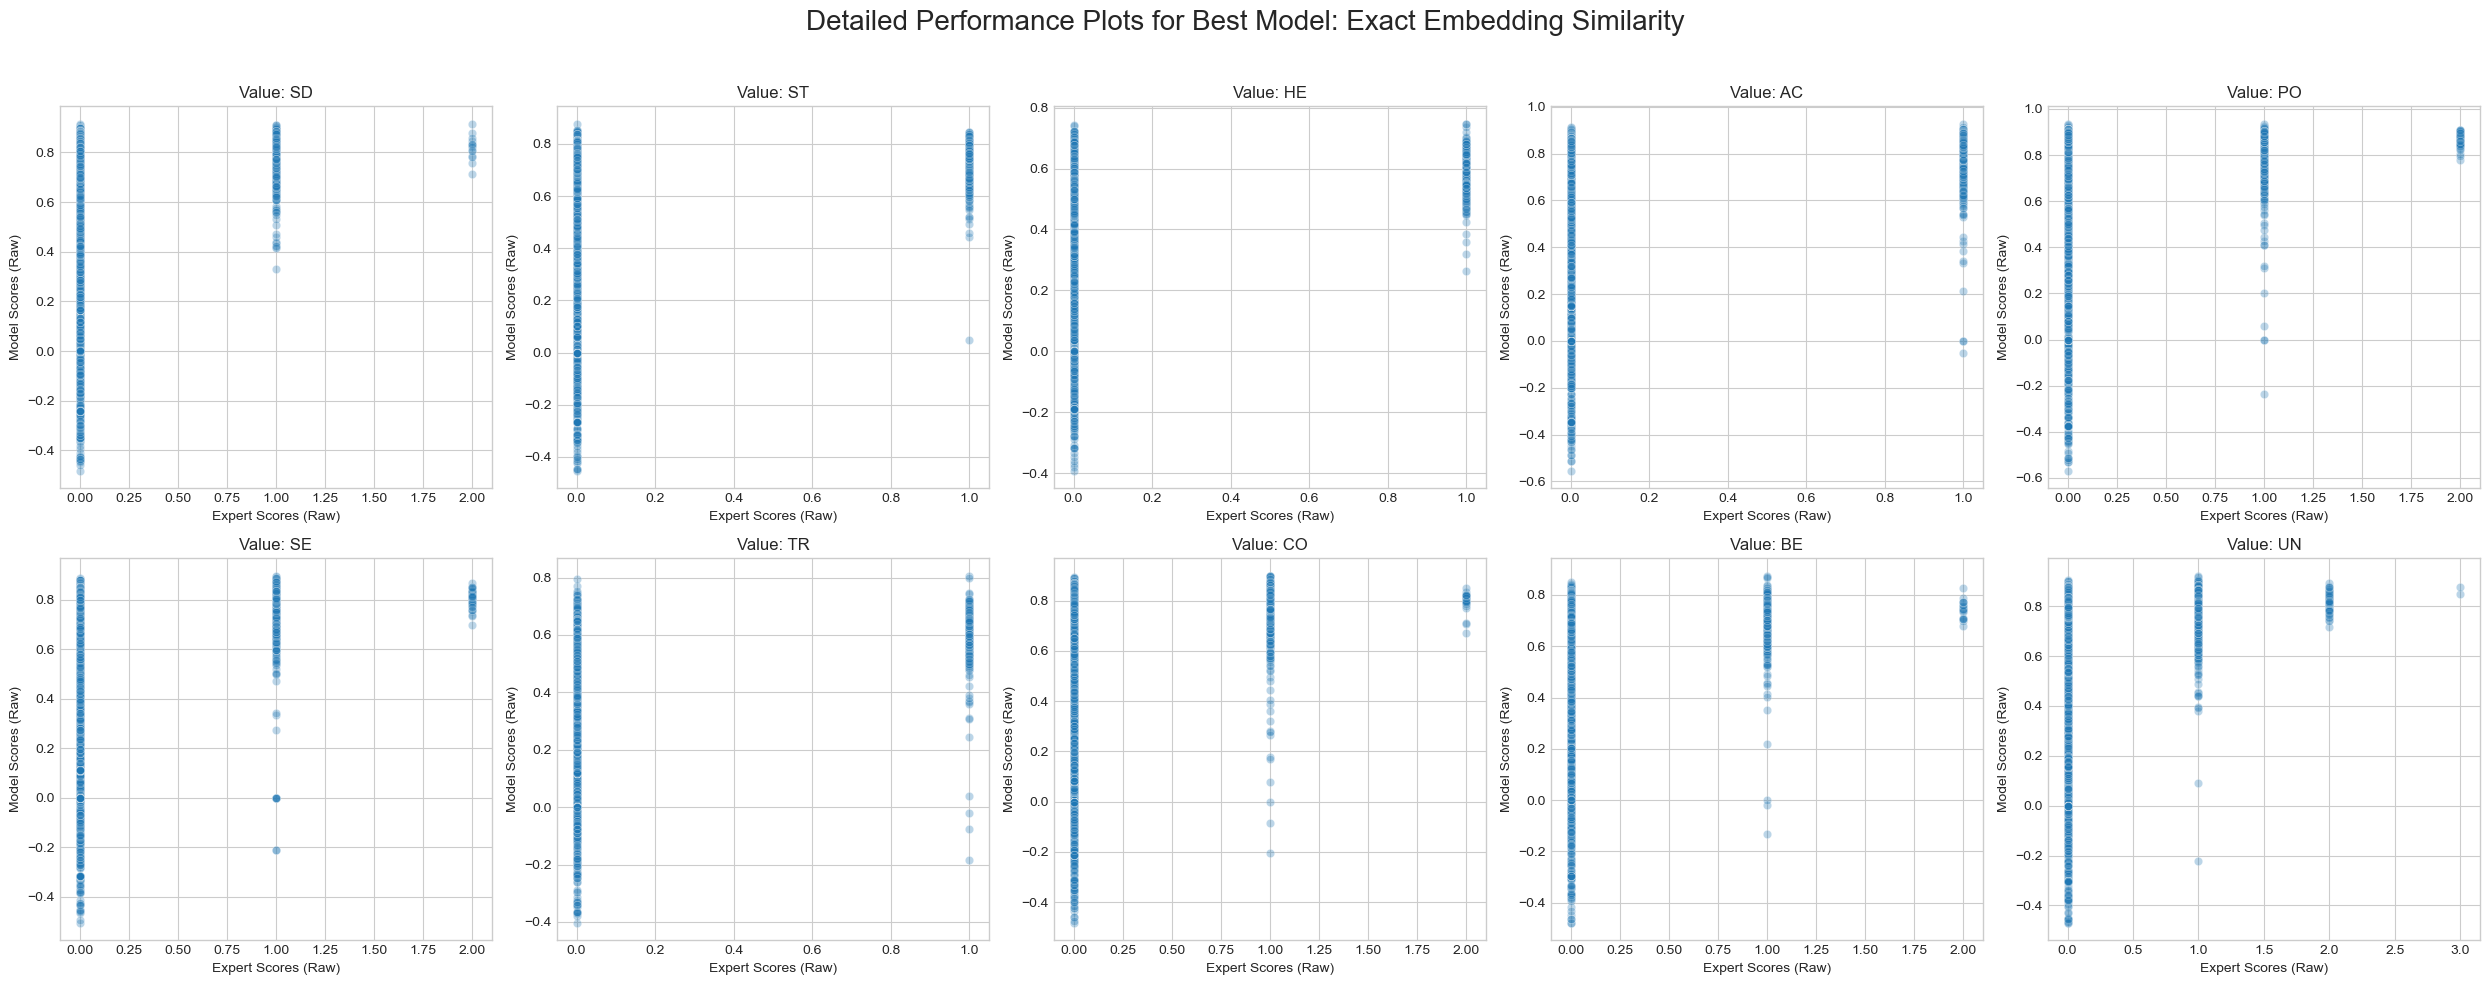

[INFO] Detailed performance panel plot saved to 'performance_plots/performance_plots_panel.png'


In [ ]:
print("\n--- Generating Detailed Performance Plots for Best Model ---")
output_dir_perf = "performance_plots"
os.makedirs(output_dir_perf, exist_ok=True)
best_config_name = f"{best_result['config'][0]}_{best_result['config'][1]}"
if best_config_name in all_scores:
    best_scores_df = all_scores[best_config_name]
    # Use RAW scores for this plot, not ipsatised
    raw_expert_scores_df = expert_scores_df.copy()
    raw_model_scores = {} # Recalculate raw scores for the best model
    
    # Prepare data for recalculation
    token_strat, vec_tech = best_result['config']
    
    # We need raw scores, so find them from the original 'results' list before they were dropped
    original_raw_scores_df = None
    for res in results:
        if res['tokenization'] == token_strat and res['vectorization'] == vec_tech:
                # This assumes raw scores were somehow stored or can be recalculated.
                # For simplicity, we'll recalculate them here.
                processed_pvd_best = {val: [process_dict_word(w, token_strat) for w in words] for val, words in aggregated_pvd.items()}
                processed_corpus_best = [process_corpus_text_no_stopwords(doc, token_strat) for doc in corpus]
                
                vectorizer_best, binary_scoring_best, kwargs_best = None, True, {}
                if vec_tech.startswith(('bow', 'tfidf')):
                    pvd_vocab_best = sorted(list(set(word for words in processed_pvd_best.values() for word in words)))
                    if 'tfidf' in vec_tech: vectorizer_best = TfidfVectorizer(vocabulary=pvd_vocab_best, token_pattern=r"(?u)\b\w+\b")
                    else: vectorizer_best = CountVectorizer(vocabulary=pvd_vocab_best, token_pattern=r"(?u)\b\w+\b")
                    vectorizer_best.fit([" ".join(doc) for doc in processed_corpus_best])
                    if vec_tech == 'tfidf_continuous': binary_scoring_best = False
                elif vec_tech.startswith('embedding_counting'):
                    kwargs_best['threshold'] = float(vec_tech.split('_')[-1])
                
                original_raw_scores_df = calculate_raw_scores(processed_corpus_best, processed_pvd_best, vec_tech, vectorizer_best, binary_score=binary_scoring_best, **kwargs_best)
                break
    
    if original_raw_scores_df is not None:
        comparison_df_perf = pd.concat([original_raw_scores_df.add_prefix('Automated_'), raw_expert_scores_df.add_prefix('Expert_')], axis=1)
        
        # Create a 2x5 panel figure
        fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10))
        axes = axes.flatten() # Flatten to 1D array for easy iteration

        for i, value in enumerate(ALL_VALUE_TYPES):
            ax = axes[i]
            sns.scatterplot(data=comparison_df_perf, x=f'Expert_{value}', y=f'Automated_{value}', alpha=0.3, ax=ax)
            ax.set_title(f"Value: {value}")
            ax.set_xlabel("Expert Scores (Raw)")
            ax.set_ylabel("Model Scores (Raw)")
            ax.grid(True)
        
        fig.suptitle(f"Detailed Performance Plots for Best Model: {best_config_name.replace('_', ' ').title()}", fontsize=20)
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()
    else:
        print("[ERROR] Could not find or recalculate raw scores for the best model to generate performance plots.")
